# diva_to_orbitize

This concise Jupyter tutorial explains how to load the astrophotometry of a detection (beta pic b) in DIVA+ and how to transform this table for direct use in Orbitize.

In [1]:
from astropy.table import Table

# Load the table from the URL (builded to get characterisations around beta pic in PCA reductions of the IFS instrument)
diva_table_url = "https://anis-dev.lam.fr/server/search/divap/characterisations?a=1;37;38;2;3;32;21;22;33;34;35;6;7;8;9;10;11;12;13;4;5&c=2::in::HIP_27321;34::in::IFS;35::in::PCA&f=csv"
diva_table = Table.read(diva_table_url, format="csv")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Convert the Astropy table to a Pandas DataFrame
diva_table_df = diva_table.to_pandas()

# Show the retrived DIVA+ table
diva_table_df

characterisations_id observation_date  observation_mjd  star_name  \
0                    1408       2016-10-14     57675.360693  HIP_27321   
1                    1409       2016-10-14     57675.360693  HIP_27321   
2                    1410       2016-10-14     57675.360693  HIP_27321   
3                    1407       2016-10-14     57675.360693  HIP_27321   
4                    1411       2016-10-14     57675.360693  HIP_27321   
..                    ...              ...              ...        ...   
302                  3894       2015-02-05     57058.090205  HIP_27321   
303                  3890       2015-02-05     57058.090205  HIP_27321   
304                  3893       2015-02-05     57058.090205  HIP_27321   
305                  3892       2015-02-05     57058.090205  HIP_27321   
306                  3891       2015-02-05     57058.090205  HIP_27321   

     companion_letter  object_common_name    wavelength   bandwidth  \
0                <NA>                <NA>  11751.000000  104.699730   
1                <NA>                <NA>  11855.500000  104.250313   
2                <NA>                <NA>  11959.500000  103.650093   
3                <NA>                <NA>  11646.100586  105.049606   
4                <NA>                <NA>  12062.799805  102.949738   
..                ...                 ...           ...         ...   
302              <NA>                <NA>  10501.899414  100.399849   
303              <NA>                <NA>  10110.700195   94.850067   
304              <NA>                <NA>  10402.099609   99.149940   
305              <NA>                <NA>  10303.599609   97.849968   
306              <NA>                <NA>  10206.400391   96.449852   

    instrument instrument_setup  ... separation  err_separation  \
0       SPHERE              IFS  ...   0.128447        0.003325   
1       SPHERE              IFS  ...   0.128484        0.003310   
2       SPHERE              IFS  ...   0.128543        0.003159   
3       SPHERE              IFS  ...   0.128630        0.003423   
4       SPHERE              IFS  ...   0.128719        0.003029   
..         ...              ...  ...        ...             ...   
302     SPHERE              IFS  ...   0.342841        0.006134   
303     SPHERE              IFS  ...   0.343316        0.008768   
304     SPHERE              IFS  ...   0.344022        0.006371   
305     SPHERE              IFS  ...   0.344442        0.006847   
306     SPHERE              IFS  ...   0.344691        0.007066   

     position_angle  err_position_angle       dra   err_dra      ddec  \
0           213.480               1.890 -0.070857  0.002333 -0.107135   
1           213.566               1.890 -0.071038  0.002365 -0.107060   
2           213.652               1.789 -0.071231  0.002228 -0.107002   
3           213.591               1.933 -0.071165  0.002389 -0.107150   
4           213.632               1.716 -0.071291  0.002147 -0.107173   
..              ...                 ...       ...       ...       ...   
302         211.566               1.231 -0.179469  0.003241 -0.292114   
303         211.409               1.728 -0.178915  0.004299 -0.293011   
304         211.461               1.286 -0.179549  0.003435 -0.293450   
305         211.396               1.365 -0.179435  0.003543 -0.294012   
306         211.377               1.426 -0.179467  0.003798 -0.294285   

     err_ddec  reduction_id  detection_id  
0    0.002345           224           484  
1    0.002290           224           484  
2    0.002212           224           484  
3    0.002426           224           484  
4    0.002109           224           484  
..        ...           ...           ...  
302  0.005127           519          1339  
303  0.007586           519          1339  
304  0.005286           519          1339  
305  0.005786           519          1339  
306  0.005886           519          1339  

[307 rows x 21 columns]

In [3]:
import pandas as pd
import os
import numpy as np

def diva_charac_to_orbitize(df, output_filename):

    # Select the necessary columns
    df = df[['observation_mjd', 'separation', 'err_separation', 'position_angle', 'err_position_angle', 'detection_id']]
    
    # Group the data by detection_id
    grouped = df.groupby('detection_id')

    # Check if each group has exactly one value of observation_mjd
    for name, group in grouped:
        if len(group['observation_mjd'].unique()) != 1:
            raise Exception(f"Le detection_id {name} a plus d'une valeur unique de observation_mjd.")

    # Calculate statistics for each group (mean on all the wavelenghts)
    stats = grouped.agg({
        'observation_mjd': 'first',
        'separation': lambda x: 1000 * x.mean(),
        'err_separation': lambda x: 1000*np.sqrt((x ** 2).sum()),
        'position_angle': 'mean',
        'err_position_angle': lambda x: np.sqrt((x ** 2).sum())
    })

    # Rename the columns for orbitize
    stats.columns = ['epoch', 'quant1', 'quant1_err', 'quant2', 'quant2_err']

    # Add missing columns
    stats['object'] = 1
    stats['quant_12_corr'] = 'nan'
    stats['quant_type'] = 'seppa'
    stats['instrument'] = 'defsp'

    # save in csv file
    stats.to_csv(output_filename, index_label='detection_id')

    return stats


In [4]:
# path where you want to save the astrometric DIVA+ file formated for Orbitize
path = '/Users/herve/Documents/tmp/'
orbitize_table = diva_charac_to_orbitize(diva_table_df, path + '/output.csv')


In [5]:
orbitize_table

epoch      quant1  quant1_err      quant2  quant2_err  \
detection_id                                                                 
183           57382.180523  234.166359   33.869330  213.523949   10.076031   
484           57675.360693  130.703462   26.878542  213.728333   14.603179   
500           57493.998565  193.459162   34.890462  213.923514   12.312149   
606           57647.391281  140.285949   25.291859  214.144692   13.060482   
610           57474.026107  208.505615   50.092158  214.737846   17.044355   
1339          57058.090205  336.918250   38.990822  212.518806    7.443949   
1459          57356.256475  242.394128   40.192481  213.571641   12.065317   
1941          57407.118670  224.972974   20.971276  213.400667    6.738701   

              object quant_12_corr quant_type instrument  
detection_id                                              
183                1           nan      seppa      defsp  
484                1           nan      seppa      defsp  
500                1           nan      seppa      defsp  
606                1           nan      seppa      defsp  
610                1           nan      seppa      defsp  
1339               1           nan      seppa      defsp  
1459               1           nan      seppa      defsp  
1941               1           nan      seppa      defsp

In [6]:
%matplotlib inline

from orbitize import driver

myDriver = driver.Driver(
    path + 'output.csv', # data file
    'OFTI',        # choose from: ['OFTI', 'MCMC']
    1,             # number of planets in system
    1.8,          # total mass [M_sun]
    50.9307,         # system parallax [mas]
    mass_err=0.04, # mass error [M_sun]
    plx_err=0.1482   # parallax error [mas]
)

In [7]:
s=myDriver.sampler 
orbits = s.run_sampler(100000)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<Figure size 1400x600 with 0 Axes>

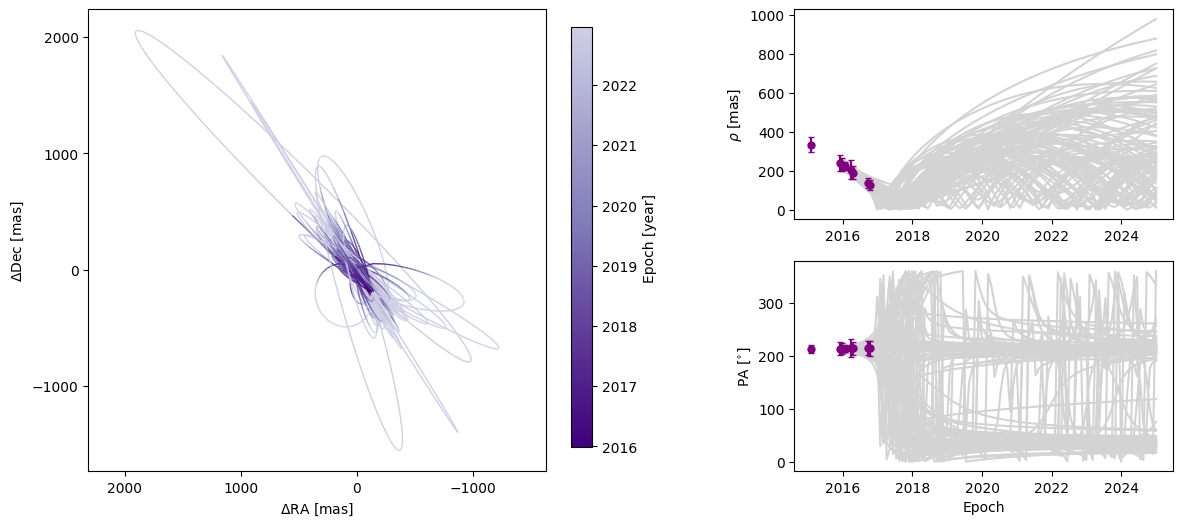

In [8]:
# plot the results
myResults = s.results
orbit_figure = myResults.plot_orbits(
    start_mjd=myDriver.system.data_table['epoch'][0] # minimum MJD for colorbar (choose first data epoch)
    , num_orbits_to_plot=100
)

In [9]:
orbit_figure.savefig(path + 'orbits.pdf')

In [10]:
myDriver.system.param_idx

{'sma1': 0,
 'ecc1': 1,
 'inc1': 2,
 'aop1': 3,
 'pan1': 4,
 'tau1': 5,
 'plx': 6,
 'mtot': 7}

In [11]:
median_values = np.median(myResults.post,axis=0) # Compute median of each parameter

# remove plx (index 6)
median_values_custom = np.delete(median_values, 6)

# Select the 3rd, 4th, and 5th elements of the array
selected_elements = median_values_custom[2:5]

# Multiply the selected elements by (180/π)
selected_elements *= 180. / np.pi

print(median_values_custom)

[  6.76977776   0.40152233  89.15910223 179.41201833 180.99057945
   0.68652559   1.79938094]


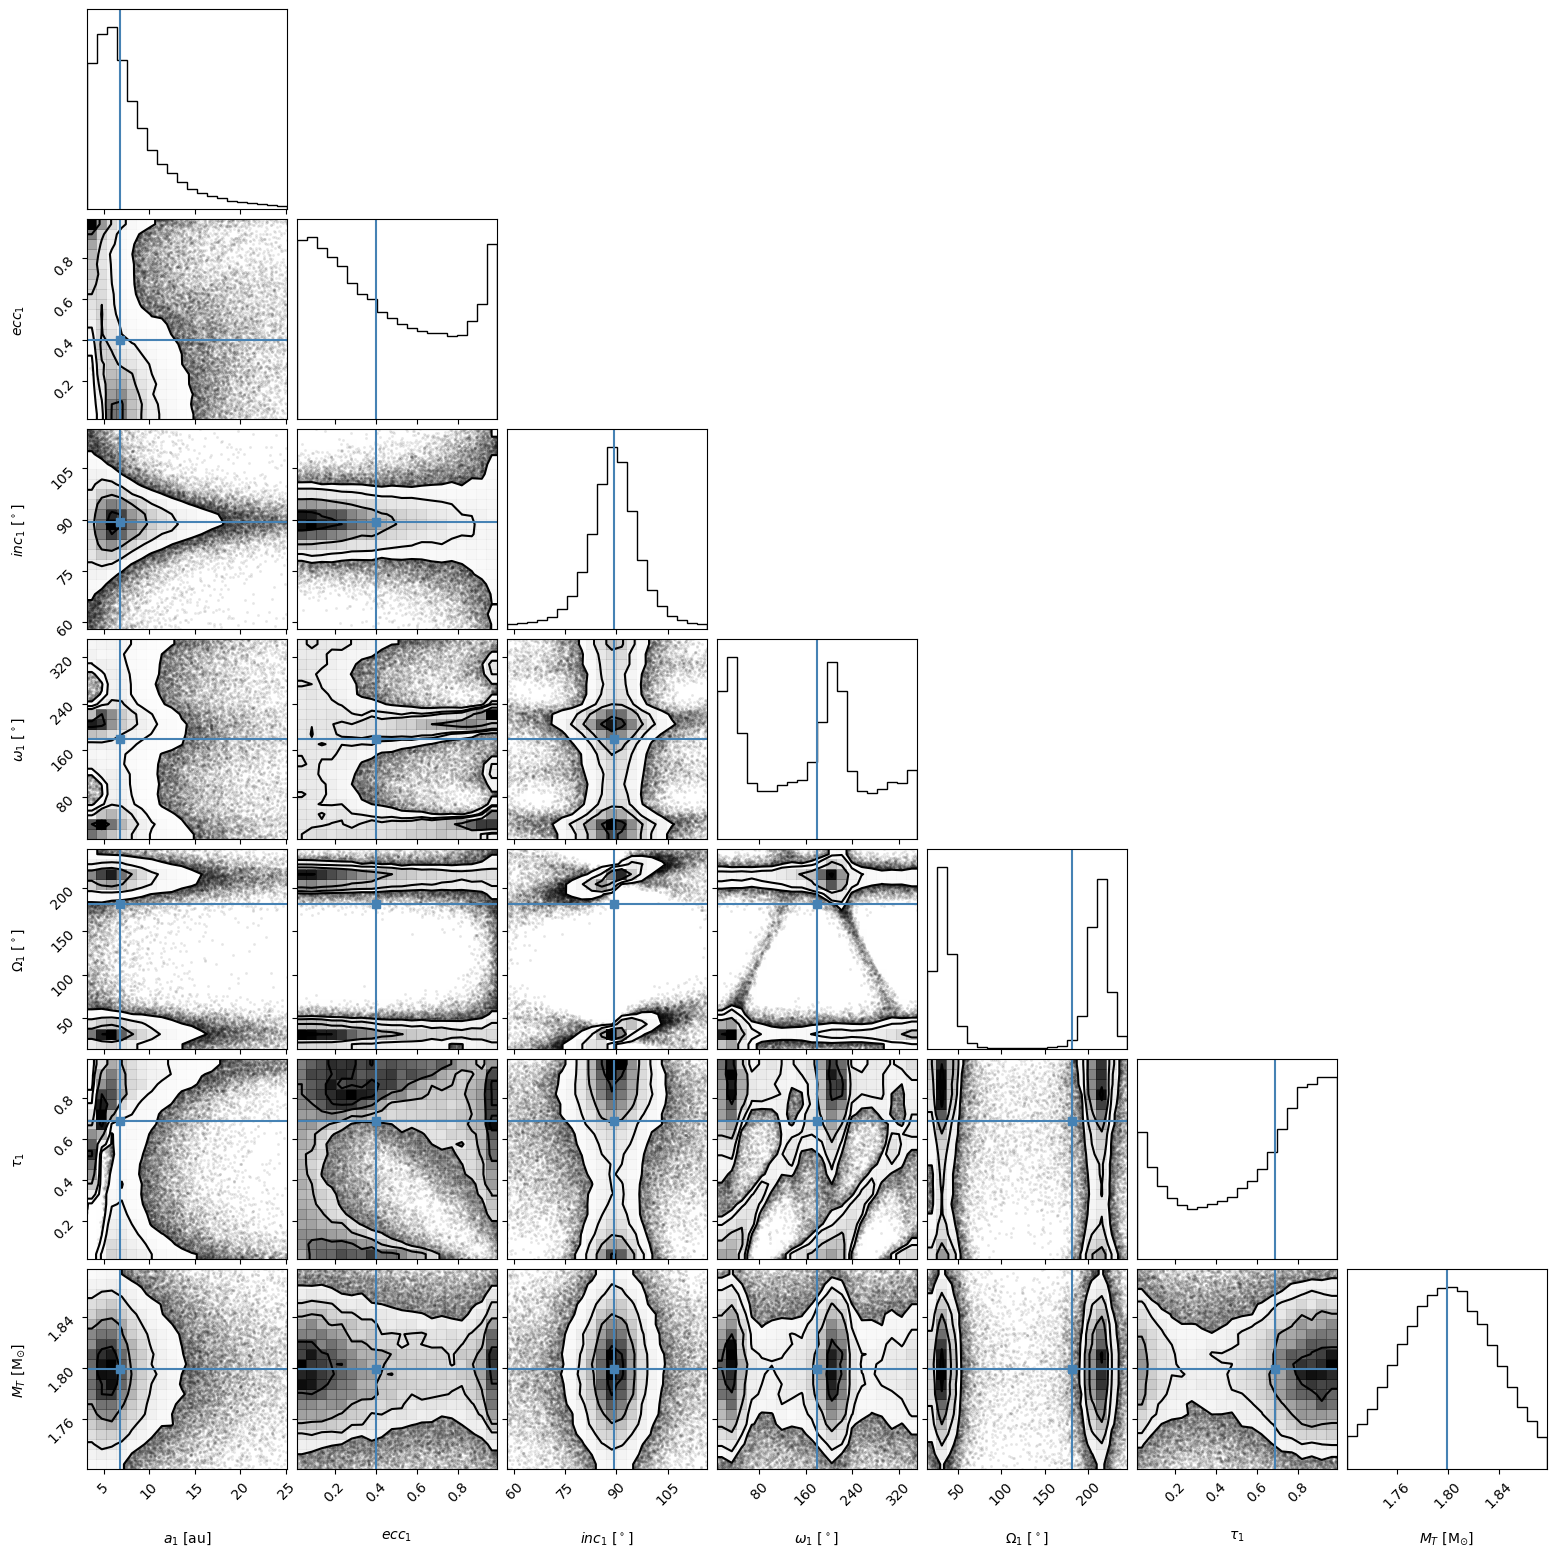

In [12]:
range_values = np.ones_like(median_values)*0.95 # Plot only 95% range for each parameter

corner_figure_median_95 = myResults.plot_corner(
    param_list=['sma1', 'ecc1', 'inc1', 'aop1', 'pan1','tau1','mtot'],
    range=(0.95,0.95,0.95,0.95,0.95,0.95,0.95), truths=median_values_custom)

In [13]:
corner_figure_median_95.savefig(path + 'cornerplot_median.pdf')

In [14]:
s.results.save_results(path + 'orbits.hdf5')